### Нейронная сеть. Создание. Обучение. Выводы

In [1]:
import cv2
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont

from cv2 import CascadeClassifier
from PIL import Image
from IPython.display import display, Image, clear_output

import pandas as pd
import dlib

import tensorflow as tf
from tensorflow import keras


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils


%pylab inline


Populating the interactive namespace from numpy and matplotlib


#### работаем с уже созданным ранее датафреймом

In [2]:
df = pd.read_csv('foto_frame1.csv')
#print(df)

In [3]:
df['kind'].value_counts()

0    1584
1    1278
2    1248
Name: kind, dtype: int64

In [4]:
# считываем изображения по имени, сохраняем в массив данные

def foto_to_array(x_array, size):
    x = np.zeros((len(x_array), size, size))
    
    i = 0
    for name in x_array:
        image = cv2.imread('foto_resized/' + name)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        x[i] = np.array(gray_img)
        i += 1
        
    return x

In [6]:
x_new = foto_to_array(df['foto'].values, 128)
y_new = df['kind'].values


In [7]:
#Делим тестовую и обучающую выборки

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size = 0.25, random_state = 123)

# В нашем случае входными значениями являются пиксели в изображении, которые имеют значение от 0 до 255.
# Если значения входных данных находятся в слишком широком диапазоне, это может отрицательно повлиять на работу сети. 
# Желательно нормализовать данные

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
#x_train.shape[1:]

# При определении класса применяем "двоичную классификацию" 
# изображение либо принадлежит одному определённому классу, либо нет
# Для унитарного кодирования используется команда Numpy to_categorical(). 

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [8]:
# количество классов, которые будем определять
num_classes = 3

In [9]:
#from keras.datasets import cifar10
#(XX_train, yy_train), (XX_test, yy_test) = cifar10.load_data()
#yy_train.shape

#### построение модели

In [10]:
# Создаем пустую модель. Sequential — классическая модель в Keras:
model = Sequential()

In [11]:
# Первый слой модели - это сверточный слой. Принимает входные данные и пропускать их через сверточные фильтры.

# - Количество каналов (фильтров):  32, 
# - размер фильтра:  (3 x 3), 
# - задаем форму входа (100*100 - размер фото, 1 - градации серого), 
# - отступы: padding = 'same' (то есть, мы не меняем размер изображения)
# - функция активации: relu 

model.add(Conv2D(32, (3, 3), input_shape = (128, 128, 1), activation = 'relu', padding='same'))

# Исключающий слой для предотвращения переобучения, который случайным образом устраняет соединения между слоями 
# 0,2 означает, что он отбрасывает 20% существующих соединений:

model.add(Dropout(0.2))

# Пакетная нормализация входных данных, поступающих в следующий слой. 
# Т.о. сеть всегда создает функции активации с тем же распределением, которое нам нужно:

model.add(BatchNormalization())

# Следующий сверточный слой, но размер фильтра увеличивается (сеть уже может изучать более сложные представления):

model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))


# Основа рабочего процесса в первой части реализации CNN: свертка, активация, исключение, объединение.
# Следующий шаг:
# - Объединяющий слой - помогает сделать классификатор изображений более корректным, чтобы он мог изучать релевантные шаблоны. 
# - Исключение (Dropout) 
# - Пакетная нормализация

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Повторяем эти слои:

#model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# После того, как закончили со сверточными слоями,нужно сжать данные. (и добавляем слой исключения снова)
model.add(Flatten())
model.add(Dropout(0.2))

# Cоздаем первый плотно связанный слой (указываем количество нейронов в плотном слое)
# Число нейронов в последующих слоях будет теперь уменьшаться, 
# в конечном итоге приближаясь к тому же числу нейронов, что и классы в наборе данных (в данном случае 3). 
# maxnorm - ограничение ядра может упорядочить данные в процессе обучения, помогает предотвратить переобучение.
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# В последнем слое мы уравниваем количество классов с числом нейронов. 
# Каждый нейрон представляет класс, поэтому на выходе этого слоя будет вектор из 3 нейронов, 
# каждый из которых хранит некоторую вероятность того, что рассматриваемое изображение принадлежит его классу.
# Функция активации softmax выбирает нейрон с наибольшей вероятностью в качестве своего выходного значения, 
# предполагая, что изображение принадлежит именно этому классу:

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# количество эпох для обучения = ?
# оптимизатор - настроит веса в сети так, чтобы приблизиться к точке с наименьшими потерями. 
# Алгоритм Адама является одним из наиболее часто используемых оптимизаторов

optimizer = 'adam'

# компилируем модель с выбранными параметрами. метрику для оценки = accuracy

model.compile(loss ='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0

#### обучение модели

In [13]:
# SEED (симметричный блочный криптоалгоритм на основе Сети Фейстеля)
seed = 21
numpy.random.seed(seed)

In [14]:
epochs = 300

In [15]:
numpy.random.seed(seed)
result = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs)

Epoch 1/300
97/97 [==============================] - 572s 6s/step - loss: 1.1099 - accuracy: 0.5084 - val_loss: 1.0934 - val_accuracy: 0.3823
Epoch 2/300
97/97 [==============================] - 548s 6s/step - loss: 0.7010 - accuracy: 0.7012 - val_loss: 1.0703 - val_accuracy: 0.3813
Epoch 3/300
97/97 [==============================] - 537s 6s/step - loss: 0.4838 - accuracy: 0.8056 - val_loss: 2.1818 - val_accuracy: 0.3823
Epoch 4/300
97/97 [==============================] - 539s 6s/step - loss: 0.4027 - accuracy: 0.8413 - val_loss: 1.1228 - val_accuracy: 0.4815
Epoch 5/300
97/97 [==============================] - 538s 6s/step - loss: 0.4189 - accuracy: 0.8374 - val_loss: 1.1458 - val_accuracy: 0.4912
Epoch 6/300
97/97 [==============================] - 536s 6s/step - loss: 0.4332 - accuracy: 0.8264 - val_loss: 1.0842 - val_accuracy: 0.6012
Epoch 7/300
97/97 [==============================] - 536s 6s/step - loss: 0.3583 - accuracy: 0.8559 - val_loss: 0.4132 - val_accuracy: 0.8648
Epoch 

In [16]:
import time
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model.save(str(time.time()))

Accuracy: 95.43%
INFO:tensorflow:Assets written to: 1637332404.682136\assets


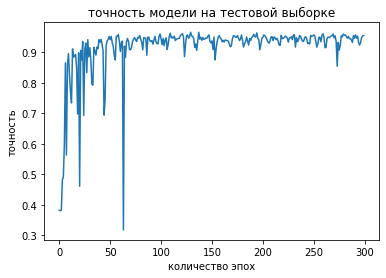

In [18]:
# график зависимости от количества эпох
plt.plot(result.history['val_accuracy'])
plt.title('точность модели на тестовой выборке')
plt.ylabel('точность')
plt.xlabel('количество эпох')
# сохраняем
plt.savefig('./f_acc.png')
plt.show()

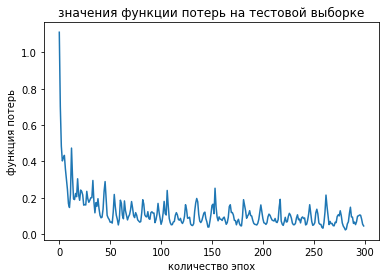

In [19]:
# график зависимости от количества эпох
plt.plot(result.history['val_loss'])
plt.title('значения функции потерь на тестовой выборке')
plt.ylabel('функция потерь')
plt.xlabel('количество эпох')

plt.savefig('./f_loss.png')
plt.show()

In [18]:
import skimage
from skimage import transform

# сравниваем результаты, которые дает обученная модель на тестовой выборке с исходным типом лица

pred = array([argmax(model.predict(x_test), axis = 1)])
norm = array([argmax(y_test, axis = 1)])

loss_list = []
for i in range(shape(pred)[1]):
    if pred[0][i] != norm[0][i]:
        loss_list.append((i, pred[0][i], norm[0][i]))


In [186]:
# функция рисует ключевые линии на фото 

def print_line (x, num):
    
    uint_img = np.array(x).astype('uint8')
    gray_img = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
    img_copy = gray_img.copy()
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")
   
    faces = detector(gray_img)

    for face in faces:

# Получение координат контрольных точек и их построение на изображении
        landmarks = predictor(gray_img, face)
    
        x_n = landmarks.part(27).x
        y_n = landmarks.part(27).y
        cv2.circle(img_copy, (x_n, y_n), 1, (0, 0, 255), 1)
    
        x_gn = landmarks.part(8).x
        y_gn = landmarks.part(8).y
        cv2.circle(img_copy, (x_gn, y_gn), 1, (0, 0, 255), 1)
    
        cv2.line(img_copy, (x_n, y_n), (x_gn, y_gn), (0, 0, 255), thickness= 1, lineType=1)
    
    
        x_zy1 = landmarks.part(0).x
        y_zy1 = landmarks.part(0).y
        cv2.circle(img_copy, (x_zy1, y_zy1), 1, (0, 0, 255), 1)
    
        x_zy2 = landmarks.part(16).x
        y_zy2 = landmarks.part(16).y
        cv2.circle(img_copy, (x_zy2, y_zy2), 1, (0, 0, 255), 1)

    
        cv2.line(img_copy, (x_zy1, y_zy1), (x_zy2, y_zy2), (0, 0, 255), thickness= 1, lineType=1)
   
        x_go_left = landmarks.part(4).x
        y_go_left = landmarks.part(4).y
    
        x_go_right = landmarks.part(12).x
        y_go_right = landmarks.part(12).y
    
    
        for n in range(5, 11):
            if x_go_left > landmarks.part(n).x:
                x_go_left = landmarks.part(n).x
                y_go_left = landmarks.part(n).y
            
        
            if x_go_right < landmarks.part(n).x:
                x_go_right = landmarks.part(n).x
                y_go_right = landmarks.part(n).y    
                
        
        cv2.circle(img_copy, (x_go_left, y_go_left), 1, (0, 0, 255), 1)
        cv2.circle(img_copy, (x_go_right, y_go_right), 1, (0, 0, 255), 1)


        cv2.line(img_copy, (x_zy1, y_zy1), (x_go_left, y_go_left), (0, 0, 255), thickness= 1, lineType=1)
        cv2.line(img_copy, (x_go_right, y_go_right), (x_zy2, y_zy2), (0, 0, 255), thickness= 1, lineType=1)
    
    
        plt.imshow(img_copy, cmap=plt.cm.gist_gray)
        cv2.imwrite('present/'+ str(num) +'.jpg',img_copy)


In [187]:
# на печать изображение с ключевыми линиями
# тип лица указанный в датафрейме и тип лица, определенный нейронной сетью после обучения

def print_loss(kort, num):
    
    img_mass = np.copy(x_test[int(kort[0])]*255.0)
    
    if kort[1] == 0:
        test = ' - прямоугольная форма'
    elif kort[1] == 1:
        test = ' - квадратная форма'
    elif kort[1] == 2:
        test = ' - треугольная форма'
        
    if kort[2] == 0:
        real = ' - прямоугольная форма'
    elif kort[2] == 1:
        real = ' - квадратная форма'
    elif kort[2] == 2:
        real = ' - треугольная форма'
       
    print('тип лица ', kort[2]+1, real)
    print('опознан как тип ', kort[1]+1, test)
    
    print_line(img_mass, num)
    
    

тип лица  3  - треугольная форма
опознан как тип  2  - квадратная форма


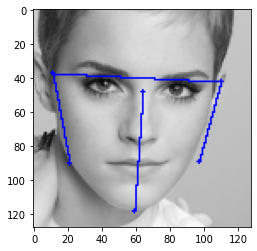

In [191]:
from PIL import Image
# Визуализируем некоторые ошибочнораспознанные типы
print_loss(loss_list[3], 3)

тип лица  1  - прямоугольная форма
опознан как тип  2  - квадратная форма


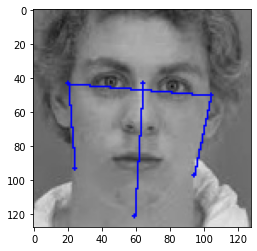

In [189]:
print_loss(loss_list[5], 5)

тип лица  2  - квадратная форма
опознан как тип  3  - треугольная форма


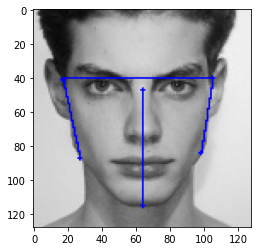

In [190]:
print_loss(loss_list[11], 11)